# Free boundary equilibrium

In this example we'll walk through solving a free boundary problem for a Solovev tokamak and a vacuum stellarator.

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../../"))

In [2]:
# from desc import set_device
# set_device("gpu")

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import desc
from desc.magnetic_fields import (
    FourierCurrentPotentialField,
    SplineMagneticField,
    field_line_integrate,
)
from desc.grid import LinearGrid
from desc.geometry import FourierRZToroidalSurface
from desc.equilibrium import Equilibrium

from desc.objectives import (
    BoundaryError,
    VacuumBoundaryError,
    FixBoundaryR,
    FixBoundaryZ,
    FixIota,
    FixCurrent,
    FixPressure,
    FixPsi,
    ForceBalance,
    ObjectiveFunction,
)
from desc.profiles import PowerSeriesProfile
from desc.vmec import VMECIO

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


DESC version 0.12.1+206.g91d82b558.dirty,using JAX backend, jax version=0.4.31, jaxlib version=0.4.31, dtype=float64
Using device: CPU, with 4.19 GB available memory


## Solovev Tokamak

In the first example, we'll solve for a free boundary tokamak with Solovev profiles.

We'll start by loading in an external field, in this case an `mgrid` file used by VMEC. The external field can also be given directly by a coilset, or from a current potential on a winding surface, or several other representations. See `desc.magnetic_fields` and `desc.coils` for more.

In [4]:
# need to specify currents in the coil circuits when using mgrid, just like in VMEC
extcur = [
    3.884526409876309e06,
    -2.935577123737952e05,
    -1.734851853677043e04,
    6.002137016973160e04,
    6.002540940490887e04,
    -1.734993103183817e04,
    -2.935531536308510e05,
    -3.560639108717275e05,
    -6.588434719283084e04,
    -1.154387774712987e04,
    -1.153546510755219e04,
    -6.588300858364606e04,
    -3.560589388468855e05,
]
ext_field = SplineMagneticField.from_mgrid(
    r"../../../tests/inputs/mgrid_solovev.nc", extcur=extcur
)

For our initial guess, we'll use a circular torus of approximately the right major and minor radius.

In [5]:
pres = PowerSeriesProfile([1.25e-1, 0, -1.25e-1])
iota = PowerSeriesProfile([-4.9e-1, 0, 3.0e-1])
surf = FourierRZToroidalSurface(
    R_lmn=[4.0, 1.0],
    modes_R=[[0, 0], [1, 0]],
    Z_lmn=[-1.0],
    modes_Z=[[-1, 0]],
    NFP=1,
)

eq_init = Equilibrium(M=10, N=0, Psi=1.0, surface=surf, pressure=pres, iota=iota)
eq_init.solve();

Building objective: force
Precomputing transforms
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed sheet current
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Number of parameters: 75
Number of objectives: 242

Starting optimization
Using method: lsq-exact
Optimization terminated successfully.
`ftol` condition satisfied.
         Current function value: 9.452e-13
         Total delta_x: 3.499e-01
         Iterations: 39
         Function evaluations: 47
         Jacobian evaluations: 40


                                                                 Start  -->   End
Total (sum of squares):                                      1.110e-01  -->   9.452e-13, 
Maximum absolute Force error:                         

In [6]:
eq2 = eq_init.copy()

Next we'll set up our constraints, which in this case simply fix the profiles, flux, and equilibrium constraint

In [7]:
constraints = (
    ForceBalance(eq=eq2),
    FixIota(eq=eq2),
    FixPressure(eq=eq2),
    FixPsi(eq=eq2),
)

Solving a free boundary equilibrium is just like any other optimization problem. In this case our objective is to minimize boundary error, which is done by the `BoundaryError` objective.

Specifically, it attempts to minimize the residual in the free boundary MHD boundary conditions:

$\mathbf{B} \cdot \mathbf{n} = 0$

$B^2_{in} + p - B^2_{out} = 0$

In [8]:
# For a standard free boundary solve, we set field_fixed=True. For single stage optimization, we would set to False
objective = ObjectiveFunction(BoundaryError(eq=eq2, field=ext_field, field_fixed=True))

In [9]:
# we know this is a pretty simple shape so we'll only use |m| <= 2
R_modes = eq2.surface.R_basis.modes[np.max(np.abs(eq2.surface.R_basis.modes), 1) > 2, :]
Z_modes = eq2.surface.Z_basis.modes[np.max(np.abs(eq2.surface.Z_basis.modes), 1) > 2, :]
bdry_constraints = (
    FixBoundaryR(eq=eq2, modes=R_modes),
    FixBoundaryZ(eq=eq2, modes=Z_modes),
)
eq2, out = eq2.optimize(
    objective,
    constraints + bdry_constraints,
    optimizer="proximal-lsq-exact",
    verbose=3,
    options={},
)

Building objective: Boundary error
Precomputing transforms
Timer: Precomputing transforms = 248 ms
Timer: Objective build = 539 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 41.6 ms
Timer: Objective build = 137 ms
Timer: Proximal projection build = 3.58 sec
Building objective: fixed iota
Building objective: fixed pressure
Building objective: fixed Psi
Building objective: lcfs R
Building objective: lcfs Z
Timer: Objective build = 467 ms
Timer: Linear constraint projection build = 857 ms
Number of parameters: 5
Number of objectives: 82
Timer: Initializing the optimization = 4.94 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          5.805e+00                                    3.235e+01   
       1              2          5.547e-01      5.250e+00      4.782e-01      7.006e+00   
       2              3          1.808e-02 

To check our solution, we can compare to a high resolution free boundary VMEC run, and we see we get extremely good agreement:

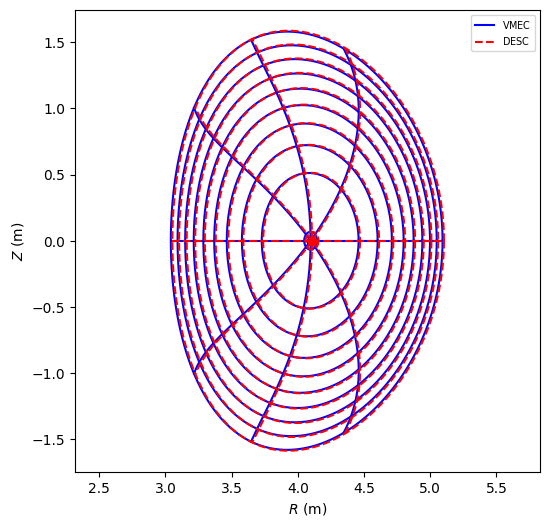

In [10]:
VMECIO.plot_vmec_comparison(eq2, "../../../tests/inputs/wout_solovev_freeb.nc");

We can plot the normal magnetic field error (the plotting function automatically will add the plasma current's contribution), and we can see that the normal field is very small for the final solution.

(<Figure size 576.162x576.162 with 2 Axes>,
 <Axes: title={'center': '$\\mathbf{B} \\cdot \\hat{n} ~(\\mathrm{T})$'}, xlabel='$\\zeta$', ylabel='$\\theta$'>)

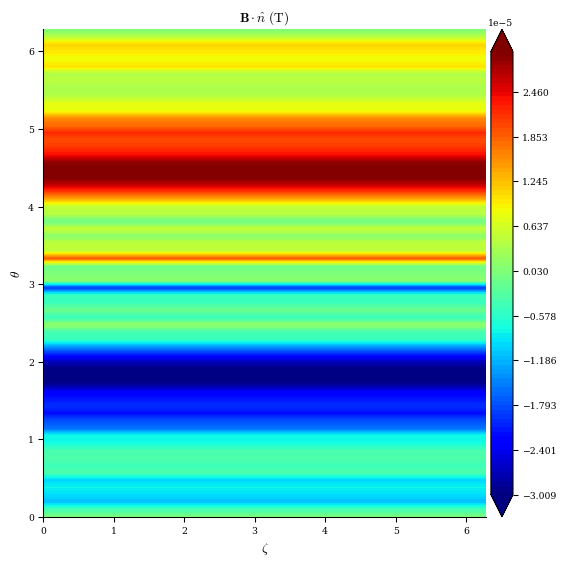

In [11]:
desc.plotting.plot_2d(eq2, "B*n", field=ext_field)

If a sheet current is known (or suspected) to exist on the plasma surface (such as if the pressure at the edge is nonzero), this can be modelled by making the equilibrium `surface` into a `FourierCurrentPotentialField`.

$\mu_0 \nabla \Phi = \mathbf{n} \times (\mathbf{B}_{out} - \mathbf{B}_{in})$

Where $\Phi$ is the current potential on the surface.


The current potential is represented as a `FourierCurrentPotentialField` which is a subclass of the standard `FourierRZToroidalSurface`. To include it as part of the free boundary calculation, we set the equilibrium surface to be an instance of `FourierCurrentPotentialField` by converting  the existing surface:

In [12]:
eq3 = eq2.copy()
eq3.surface = FourierCurrentPotentialField.from_surface(eq3.surface, M_Phi=4)

In [13]:
constraints = (
    ForceBalance(eq=eq3),
    FixIota(eq=eq3),
    FixPressure(eq=eq3),
    FixPsi(eq=eq3),
)
objective = ObjectiveFunction(BoundaryError(eq=eq3, field=ext_field, field_fixed=True))

In [14]:
R_modes = eq3.surface.R_basis.modes[np.max(np.abs(eq3.surface.R_basis.modes), 1) > 2, :]
Z_modes = eq3.surface.Z_basis.modes[np.max(np.abs(eq3.surface.Z_basis.modes), 1) > 2, :]
bdry_constraints = (
    FixBoundaryR(eq=eq3, modes=R_modes),
    FixBoundaryZ(eq=eq3, modes=Z_modes),
)
eq3, out = eq3.optimize(
    objective,
    constraints + bdry_constraints,
    optimizer="proximal-lsq-exact",
    verbose=3,
    options={},
)

Building objective: Boundary error
Precomputing transforms
Timer: Precomputing transforms = 315 ms
Timer: Objective build = 413 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 38.5 ms
Timer: Objective build = 134 ms
Timer: Proximal projection build = 2.39 sec
Building objective: fixed iota
Building objective: fixed pressure
Building objective: fixed Psi
Building objective: lcfs R
Building objective: lcfs Z
Timer: Objective build = 419 ms
Timer: Linear constraint projection build = 749 ms
Number of parameters: 11
Number of objectives: 123
Timer: Initializing the optimization = 3.61 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          8.049e-06                                    4.399e-03   
       1              7          7.959e-06      8.966e-08      1.069e+02      1.255e-03   
       2              8          7.796e-0

We can see that including the sheet current makes very little difference in the final result:

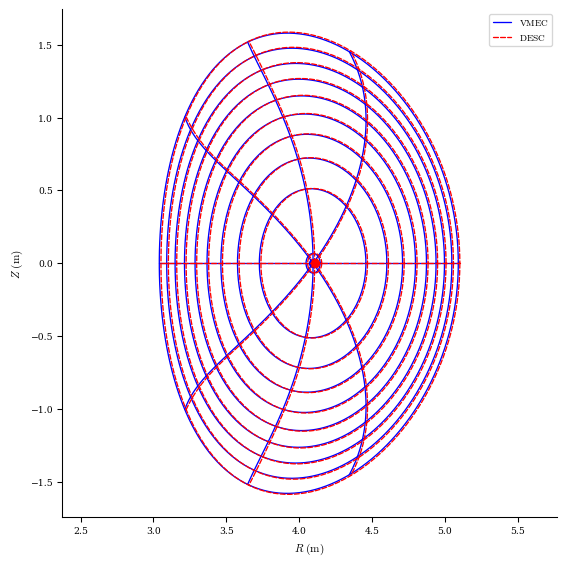

In [15]:
VMECIO.plot_vmec_comparison(eq3, "../../../tests/inputs/wout_solovev_freeb.nc");

We can see that the normal field error decreased slighlty, though not by much:

(<Figure size 576.162x576.162 with 2 Axes>,
 <Axes: title={'center': '$\\mathbf{B} \\cdot \\hat{n} ~(\\mathrm{T})$'}, xlabel='$\\zeta$', ylabel='$\\theta$'>)

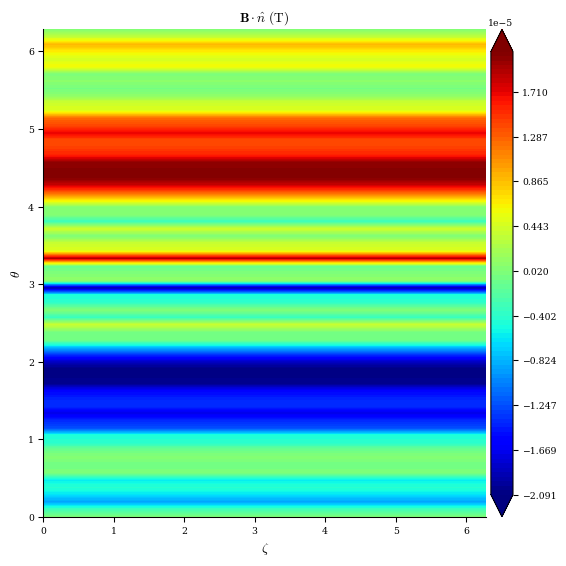

In [16]:
desc.plotting.plot_2d(eq3, "B*n", field=ext_field)

We can examine what the surface current looks like by plotting it below, and we see it is indeed quite small, only a few tens of Amps, compared to the plasma current which is ~1000x larger. In this case we could probably get equivalent results without including the sheet current term.

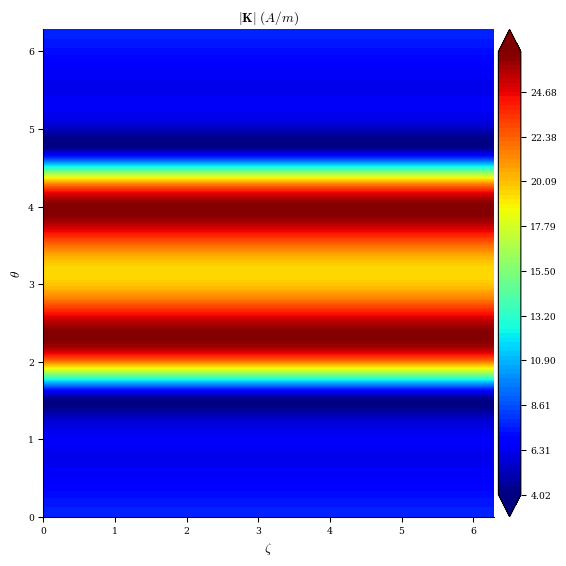

In [17]:
desc.plotting.plot_2d(eq3.surface, "K");

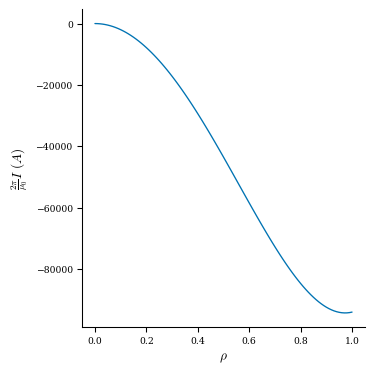

In [18]:
desc.plotting.plot_1d(eq3, "current");

## Vacuum Stellarator

We'll again use an mgrid file for our background field:

In [19]:
extcur = [4700.0, 1000.0]
ext_field = SplineMagneticField.from_mgrid(
    "../../../tests/inputs/mgrid_test.nc", extcur=extcur
)

For our initial guess, we'll again use a circular torus of approximately the right major and minor radius.

In [20]:
surf = FourierRZToroidalSurface(
    R_lmn=[0.70, 0.10],
    modes_R=[[0, 0], [1, 0]],
    Z_lmn=[-0.10],
    modes_Z=[[-1, 0]],
    NFP=5,
)

eq_init = Equilibrium(M=6, N=6, Psi=-0.035, surface=surf)
eq_init.solve();

Building objective: force
Precomputing transforms
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed sheet current
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Number of parameters: 375
Number of objectives: 2450

Starting optimization
Using method: lsq-exact
`gtol` condition satisfied.
         Current function value: 1.514e-18
         Total delta_x: 2.119e-01
         Iterations: 66
         Function evaluations: 72
         Jacobian evaluations: 67


                                                                 Start  -->   End
Total (sum of squares):                                      1.158e-02  -->   1.514e-18, 
Maximum absolute Force error:                                9.655e+03  -->   4.722e-04

In [21]:
eq2 = eq_init.copy()

And again we'll set up our constraints.

In [22]:
constraints = (
    ForceBalance(eq=eq2),
    FixCurrent(eq=eq2),
    FixPressure(eq=eq2),
    FixPsi(eq=eq2),
)

The `BoundaryError` objective we just used uses the virtual casing principle to compute the plasma component of the magnetic field, required to compute the boundary error. If we know we're solving a vacuum equilibrium, we can skip this calculating since we know the plasma component of the field is zero. This is done in the `VacuumBoundaryError` objective, which is much more efficient for vacuum equilibria.

In [23]:
objective = ObjectiveFunction(
    VacuumBoundaryError(eq=eq2, field=ext_field, field_fixed=True)
)

For the optimization, we'll do a "multigrid" approach where we first optimize the low order modes, and then the higher ones. For a simple problem like this it probably isn't necessary, but for higher resolution and more complicated shaping this is much more robust.

In [24]:
for k in [2, 4]:

    # get modes where |m|, |n| > k
    R_modes = eq2.surface.R_basis.modes[
        np.max(np.abs(eq2.surface.R_basis.modes), 1) > k, :
    ]
    Z_modes = eq2.surface.Z_basis.modes[
        np.max(np.abs(eq2.surface.Z_basis.modes), 1) > k, :
    ]

    # fix those modes
    bdry_constraints = (
        FixBoundaryR(eq=eq2, modes=R_modes),
        FixBoundaryZ(eq=eq2, modes=Z_modes),
    )
    # optimize
    eq2, out = eq2.optimize(
        objective,
        constraints + bdry_constraints,
        optimizer="proximal-lsq-exact",
        verbose=3,
        options={},
    )

Building objective: Vacuum boundary error
Precomputing transforms
Timer: Precomputing transforms = 179 ms
Timer: Objective build = 549 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 41.1 ms
Timer: Objective build = 147 ms
Timer: Proximal projection build = 4.49 sec
Building objective: fixed current
Building objective: fixed pressure
Building objective: fixed Psi
Building objective: lcfs R
Building objective: lcfs Z
Timer: Objective build = 645 ms
Timer: Linear constraint projection build = 1.61 sec
Number of parameters: 25
Number of objectives: 1250
Timer: Initializing the optimization = 6.80 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          2.181e+00                                    1.085e+02   
       1              2          3.556e-01      1.825e+00      7.801e-02      2.755e+01   
       2              3     

And we see that the boundary has changed quite a lot:

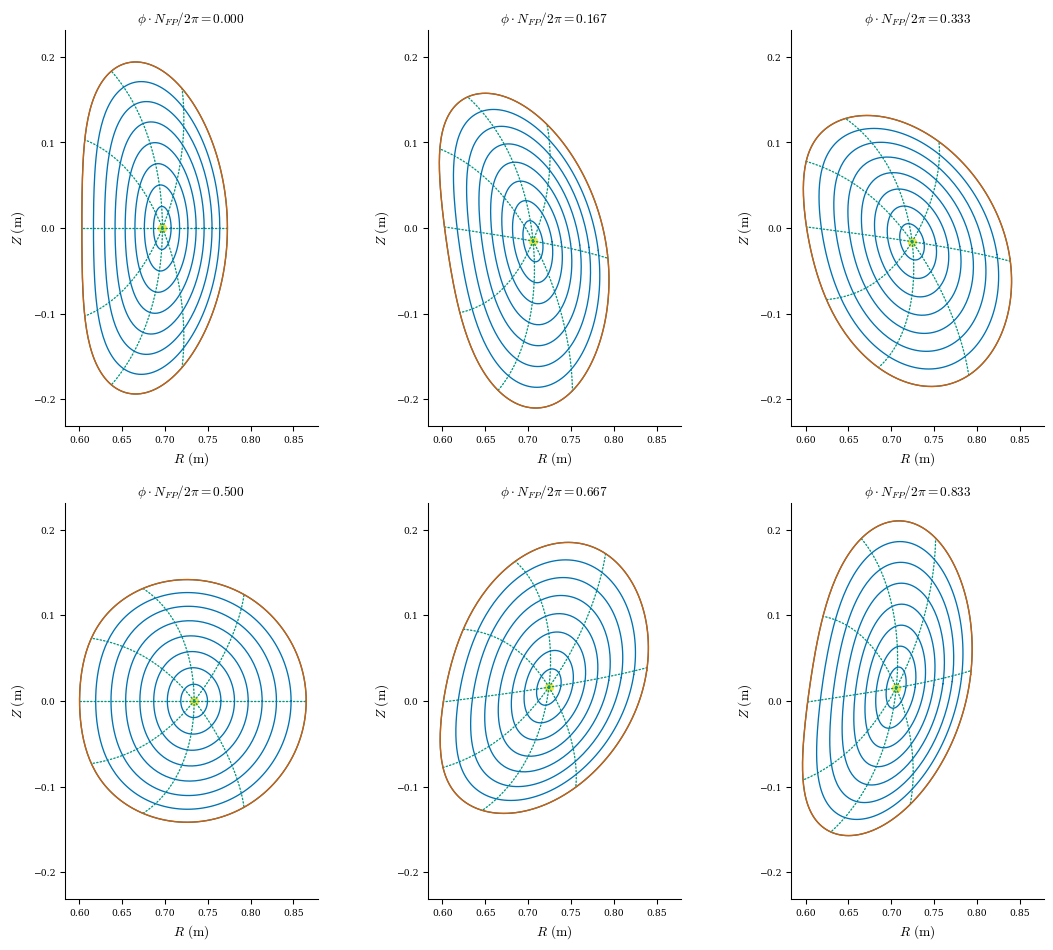

In [25]:
desc.plotting.plot_surfaces(eq2);

Because this is a vacuum equilibrium, we can verify the free boundary solution by tracing field lines directly from the external field:

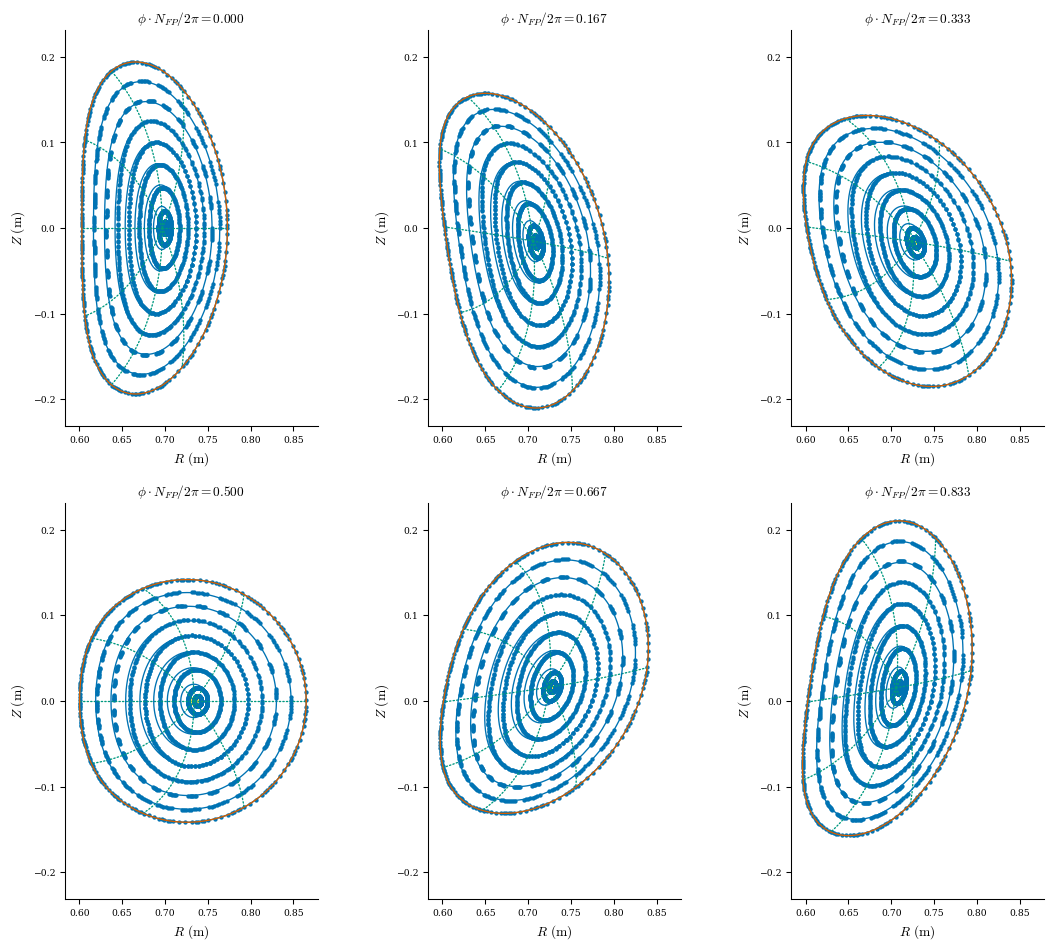

In [26]:
fig, ax = desc.plotting.plot_surfaces(eq2)

# for starting locations we'll pick positions on flux surfaces on the outboard midplane
grid_trace = LinearGrid(rho=np.linspace(0, 1, 9))
r0 = eq2.compute("R", grid=grid_trace)["R"]
z0 = eq2.compute("Z", grid=grid_trace)["Z"]

fig, ax = desc.plotting.poincare_plot(
    ext_field, r0, z0, ntransit=200, NFP=eq2.NFP, ax=ax
);